# XGBoost Starter Notebook
This is a starter notebook for Kaggle's August Playground competition. It trains an XGBoost model with some feature engineering and achieves CV 0.976. This notebook shows some techniques that I have used in previous Kaggle playground competitions to perform well.

This notebook demonstrates at least these 5 things:
* How to create new categorical features from pairs of existing categorical features
* How to use original data as new columns
* How to use original data as new rows
* How to categorical encode (with CE count encoding and TE target encoding)
* How to train XGB with big data using memory efficient QuantileDMatrix

# NVIDIA cuDF Pandas
We accelerate our notebook with the magic command `%load_ext cudf.pandas`. Afterward, all calls to Pandas will run NVIDIA cuDF on GPU (instead of Pandas on CPU). This makes our notebook run faster!

In [2]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


# Load Data
We load train, test, and original datasets. In every Kaggle playground competition, the data is synthetic and it is generated from an original dataset. In this competition, the original dataset is [here][1]

[1]: https://www.kaggle.com/datasets/sushant097/bank-marketing-dataset-full

In [3]:
import pandas as pd, numpy as np, os

PATH = "/kaggle/input/playground-series-s5e8/"
train = pd.read_csv(f"{PATH}train.csv").set_index('id')
print("Train shape", train.shape )
train.head()

Train shape (750000, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
test = pd.read_csv(f"{PATH}test.csv").set_index('id')
test['y'] = -1
print("Test shape", test.shape )
test.head()

Test shape (250000, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown,-1
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown,-1
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown,-1
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown,-1
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown,-1


# EDA (Exploratory Data Analysis)
We now combine all data together and then explore the columns and their properties. We observe that there is no missing data. And we observe that the categorical columns have low cardinality (i.e. under 12). We observe that most numerical columns have few unique values, and two numerical columns have around 2k and 8k unique values.

In [16]:
combine = pd.concat([train,test],axis=0)
print("Combined data shape", combine.shape )

Combined data shape (1000000, 280)


In [8]:
CATS = []
NUMS = []
for c in combine.columns[:-1]:
    t = "CAT"
    if combine[c].dtype=='object':
        CATS.append(c)
    else:
        NUMS.append(c)
        t = "NUM"
    n = combine[c].nunique()
    na = combine[c].isna().sum()
    print(f"[{t}] {c} has {n} unique and {na} NA")
print("CATS:", CATS )
print("NUMS:", NUMS )

[NUM] age has 78 unique and 0 NA
[CAT] job has 12 unique and 0 NA
[CAT] marital has 3 unique and 0 NA
[CAT] education has 4 unique and 0 NA
[CAT] default has 2 unique and 0 NA
[NUM] balance has 8469 unique and 0 NA
[CAT] housing has 2 unique and 0 NA
[CAT] loan has 2 unique and 0 NA
[CAT] contact has 3 unique and 0 NA
[NUM] day has 31 unique and 0 NA
[CAT] month has 12 unique and 0 NA
[NUM] duration has 1798 unique and 0 NA
[NUM] campaign has 52 unique and 0 NA
[NUM] pdays has 614 unique and 0 NA
[NUM] previous has 53 unique and 0 NA
[CAT] poutcome has 4 unique and 0 NA
CATS: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
NUMS: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


# Feature Engineer (LE - Label Encode)
We will label encode all categorical columns. Also we will make a duplicate of each numerical column and treat the copy as a categorical column.

In [9]:
CATS1 = []
SIZES = {}
for c in NUMS + CATS:
    n = c
    if c in NUMS: 
        n = f"{c}2"
        CATS1.append(n)
    combine[n],_ = combine[c].factorize()
    SIZES[n] = combine[n].max()+1

    combine[c] = combine[c].astype('int32')
    combine[n] = combine[n].astype('int32')

print("New CATS:", CATS1 )
print("Cardinality of all CATS:", SIZES )

New CATS: ['age2', 'balance2', 'day2', 'duration2', 'campaign2', 'pdays2', 'previous2']
Cardinality of all CATS: {'age2': 78, 'balance2': 8469, 'day2': 31, 'duration2': 1798, 'campaign2': 52, 'pdays2': 614, 'previous2': 53, 'job': 12, 'marital': 3, 'education': 4, 'default': 2, 'housing': 2, 'loan': 2, 'contact': 3, 'month': 12, 'poutcome': 4}


# Feature Engineer (Combine Column Pairs)
We will create a new categorical column from every pair of existing categorical columns. The original categorical columns have been label encoded into integers from `0 to N-1` each. Therefore we can create a new column with unique integers using the formula `new_cols[name] = combine[c1] * SIZES[c2] + combine[c2]`.

In [10]:
from itertools import combinations

pairs = combinations(CATS + CATS1, 2)
new_cols = {}
CATS2 = []

for c1, c2 in pairs:
    s = SIZES[c1] * SIZES[c2]
    name = "_".join(sorted((c1, c2)))
    new_cols[name] = combine[c1] * SIZES[c2] + combine[c2]
    CATS2.append(name)
if new_cols:
    new_df = pd.DataFrame(new_cols)         
    combine = pd.concat([combine, new_df], axis=1) 

print(f"Created {len(CATS2)} new CAT columns")

Created 120 new CAT columns


# Feature Engineer (CE - Count Encoding)
We now have 136 categorical columns. We will count encode each of them and create 136 new columns.

In [11]:
CE = []
CC = CATS+CATS1+CATS2

print(f"Processing {len(CC)} columns... ",end="")
for i,c in enumerate(CC):
    if i%10==0: print(f"{i}, ",end="")
    tmp = combine.groupby(c).y.count()
    tmp = tmp.astype('int32')
    tmp.name = f"CE_{c}"
    CE.append( f"CE_{c}" )
    combine = combine.merge(tmp, on=c, how='left')
print()

Processing 136 columns... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 


In [17]:
train = combine.iloc[:len(train)]
test = combine.iloc[len(train):len(train)+len(test)]


print("Train shape", train.shape,"Test shape", test.shape,"Original shape" )

Train shape (750000, 280) Test shape (250000, 280) Original shape


# Train XGB w/ Original Data as Rows
We will now train XGBoost with adding original data as new rows. Inside each KFold for loop iteration, we will concatenate the original data to the train data as new rows. 

We will also use a `QuantileDMatrix` instead of a `DMatrix`. This reduces memory usage because the data will be loaded into GPU VRAM in batches and compressed in batches. This is different than the basic `DMatrix` which tries to load all the train data into GPU VRAM at the same time which spikes the memory and can cause OOM.

In [18]:
from cuml.preprocessing import TargetEncoder
from sklearn.model_selection import KFold
import xgboost as xgb

print(f"XGBoost version {xgb.__version__}")

XGBoost version 2.0.3


## XGB Hyperparameters

In [19]:
FEATURES = NUMS+CATS+CATS1+CATS2+CE
print(f"We have {len(FEATURES)} features.")

FOLDS = 7
SEED = 42

params = {
    "objective": "binary:logistic",  
    "eval_metric": "auc",           
    "learning_rate": 0.1,
    "max_depth": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "seed": SEED,
    "device": "cuda",
    "grow_policy": "lossguide", 
    "max_leaves": 32,          
    "alpha": 2.0,
}

We have 279 features.


## Data Loader for QuantileDMatrix
We need the following data loader to use XGB's memory efficient `QuantileDMatrix`. This data loader yields batches of data on GPU for XGB.

In [20]:
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        #dt = cudf.DataFrame(self.df.iloc[a:b])
        dt = self.df.iloc[a:b]
        input_data(data=dt[self.features], label=dt[self.target]) 
        self.it += 1
        return 1

## Train XGB
## w/ Feature Engineer - (TE - NVIDIA cuML)
Inside each KFold for loop iteration, we will use NVIDIA cuML Target Encoder to target encode some high cardinality categorical features

In [22]:
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {fold+1} ###")
    print("#"*25)

    # Só usa train, ignora orig
    Xy_train = train.iloc[train_idx][FEATURES+['y']].copy()
    
    X_valid = train.iloc[val_idx][FEATURES].copy()
    y_valid = train.iloc[val_idx]['y']
    X_test = test[FEATURES].copy()

    # Target encoding
    CC = CATS1+CATS2
    print(f"Target encoding {len(CC)} features... ",end="")
    for i,c in enumerate(CC):
        if i%10==0: print(f"{i}, ",end="")
        TE0 = TargetEncoder(n_folds=10, smooth=0, split_method='random', stat='mean')
        Xy_train[c] = TE0.fit_transform(Xy_train[c],Xy_train['y']).astype('float32')
        X_valid[c] = TE0.transform(X_valid[c]).astype('float32')
        X_test[c] = TE0.transform(X_test[c]).astype('float32')
    print()

    # Converter categorias
    Xy_train[CATS] = Xy_train[CATS].astype('category')
    X_valid[CATS] = X_valid[CATS].astype('category')
    X_test[CATS] = X_test[CATS].astype('category')

    # Criar DMatrix
    Xy_train = IterLoadForDMatrix(Xy_train, FEATURES, 'y')
    dtrain = xgb.QuantileDMatrix(Xy_train, enable_categorical=True, max_bin=256)
    dval   = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest  = xgb.DMatrix(X_test, enable_categorical=True)

    # Treino
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=10_000,
        evals=[(dtrain, "train"), (dval, "valid")],
        early_stopping_rounds=200,
        verbose_eval=200
    )

    # Predições
    oof_preds[val_idx] = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
    test_preds += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) / FOLDS


#########################
### Fold 1 ###
#########################
Target encoding 127 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 
[0]	train-auc:0.95059	valid-auc:0.94928
[200]	train-auc:0.97870	valid-auc:0.97517
[400]	train-auc:0.98213	valid-auc:0.97533
[600]	train-auc:0.98489	valid-auc:0.97533
[609]	train-auc:0.98500	valid-auc:0.97533
#########################
### Fold 2 ###
#########################
Target encoding 127 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 
[0]	train-auc:0.95415	valid-auc:0.95391
[200]	train-auc:0.97872	valid-auc:0.97480
[400]	train-auc:0.98211	valid-auc:0.97508
[600]	train-auc:0.98481	valid-auc:0.97510
[668]	train-auc:0.98567	valid-auc:0.97510
#########################
### Fold 3 ###
#########################
Target encoding 127 features... 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 
[0]	train-auc:0.95095	valid-auc:0.94775
[200]	train-auc:0.97888	valid-auc:0.97396
[400]	train-auc:0.98229	valid-auc:0.9741

## CV Score

In [23]:
from sklearn.metrics import roc_auc_score

m = roc_auc_score(train.y, oof_preds)
print(f"XGB with Original Data as rows CV = {m}")

XGB with Original Data as rows CV = 0.9753289050923617


In [24]:
subm = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")
subm["y"] = test_preds
subm

,id,y
0,750000,0.001068
1,750001,0.079577
2,750002,0.000094
3,750003,0.000054
4,750004,0.010708
...,...,...
249995,999995,0.000055
249996,999996,0.036185
249997,999997,0.652432
249998,999998,0.000334


In [25]:
subm.to_csv("xgboostBaseChrisD.csv", index=False)

## Feature Importance

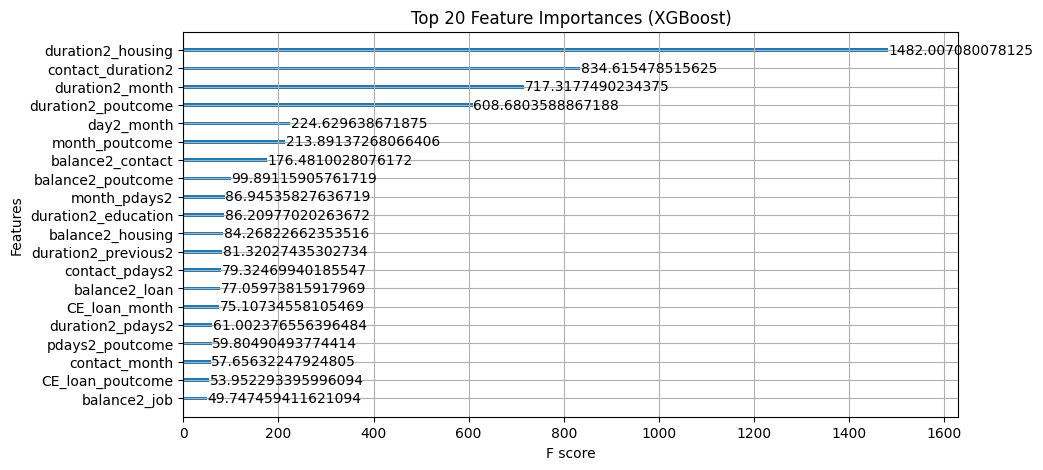

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
xgb.plot_importance(model, max_num_features=20, importance_type='gain',ax=ax)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

# Train XGB w/ Original Data as Columns
We will now train XGBoost with adding original data as new columns. We accomplish this by Target Encoding our categorical columns using the targets of the original data. Since these are not the targets of our true train.csv data, there is no leakage and we don't need to use kfold to add these new columns.

We will also use a `QuantileDMatrix` instead of a `DMatrix`. This reduces memory usage because the data will be loaded into GPU VRAM in batches and compressed in batches. This is different than the basic `DMatrix` which tries to load all the train data into GPU VRAM at the same time which spikes the memory and can cause OOM.

## Feature Engineering (TE - Original Data as Cols)
Below is a technique to add the original data as new columns.

In [ ]:
TE_ORIG = []
CC = CATS+CATS1+CATS2

print(f"Processing {len(CC)} columns... ",end="")
for i,c in enumerate(CC):
    if i%10==0: print(f"{i}, ",end="")
    tmp = orig.groupby(c).y.mean()
    tmp = tmp.astype('float32')
    tmp.name = f"TE_ORIG_{c}"
    TE_ORIG.append( f"TE_ORIG_{c}" )
    train = train.merge(tmp, on=c, how='left')
    test = test.merge(tmp, on=c, how='left')
print()

## XGB Hyperparameters

In [ ]:
FEATURES += TE_ORIG
print(f"We have {len(FEATURES)} features.")

FOLDS = 7
SEED = 42

params = {
    "objective": "binary:logistic",  
    "eval_metric": "auc",           
    "learning_rate": 0.1,
    "max_depth": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "seed": SEED,
    "device": "cuda",
    "grow_policy": "lossguide", 
    "max_leaves": 32,           
    "alpha": 2.0,
}

## Train XGB
## w/ Feature Engineer - (TE - NVIDIA cuML)
Inside each KFold for loop iteration, we will use NVIDIA cuML Target Encoder to target encode some high cardinality categorical features

In [ ]:
oof_preds2 = np.zeros(len(train))
test_preds2 = np.zeros(len(test))

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {fold+1} ###")
    print("#"*25)

    Xy_train = train.iloc[train_idx][ FEATURES+['y'] ].copy()    
    X_valid = train.iloc[val_idx][FEATURES].copy()
    y_valid = train.iloc[val_idx]['y']
    X_test = test[FEATURES].copy()

    CC = CATS1+CATS2
    print(f"Target encoding {len(CC)} features... ",end="")
    for i,c in enumerate(CC):
        if i%10==0: print(f"{i}, ",end="")
        TE0 = TargetEncoder(n_folds=10, smooth=0, split_method='random', stat='mean')
        Xy_train[c] = TE0.fit_transform(Xy_train[c],Xy_train['y']).astype('float32')
        X_valid[c] = TE0.transform(X_valid[c]).astype('float32')
        X_test[c] = TE0.transform(X_test[c]).astype('float32')
    print()

    Xy_train[CATS] = Xy_train[CATS].astype('category')
    X_valid[CATS] = X_valid[CATS].astype('category')
    X_test[CATS] = X_test[CATS].astype('category')

    Xy_train = IterLoadForDMatrix(Xy_train, FEATURES, 'y')
    dtrain = xgb.QuantileDMatrix(Xy_train, enable_categorical=True, max_bin=256)
    dval   = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest  = xgb.DMatrix(X_test, enable_categorical=True)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=10_000,
        evals=[(dtrain, "train"), (dval, "valid")],
        early_stopping_rounds=200,
        verbose_eval=200
    )

    oof_preds2[val_idx] = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
    test_preds2 += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) / FOLDS

## CV Score

In [ ]:
from sklearn.metrics import roc_auc_score

m = roc_auc_score(train.y, oof_preds2)
print(f"XGB with Original Data as columns CV = {m}")

## Feature Importance

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
xgb.plot_importance(model, max_num_features=20, importance_type='gain',ax=ax)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

# Ensemble XGB Orig Rows w/ XGB Orig Cols

In [ ]:
m = roc_auc_score(train.y, oof_preds+oof_preds2)
print(f"Ensemble CV = {m}")

# Create Submission CSV

In [ ]:
sub = pd.read_csv(f"{PATH}sample_submission.csv")
sub['y'] = (test_preds + test_preds2)/2.
sub.to_csv("submission.csv",index=False)
print('Submission shape',sub.shape)
sub.head()

## EDA Test Preds

In [ ]:
plt.hist(sub.y,bins=100)
plt.title('Test Preds')
plt.ylim((0,10_000))
plt.show()